In [31]:
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
from tqdm import tqdm

In [32]:
metadata = pd.read_csv("./data/HAM10000_metadata.csv")
metadata

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [36]:
metadata["dx"].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [44]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=90,horizontal_flip=True,vertical_flip=True,
                             brightness_range=(0.8,1.2),zoom_range=(0.8,1.2))
number = 142
current = "vasc"
batch = datagen.flow_from_directory("./data/images/",classes=[current],save_format="jpg",save_to_dir=f"./data/augmented/{current}",batch_size=1,keep_aspect_ratio=True)

for i in tqdm(range(6705-number)):
    batch.next()

Found 142 images belonging to 1 classes.


100%|██████████| 6563/6563 [01:21<00:00, 80.43it/s]


In [51]:
import shutil,os

folders = os.listdir("./data/images/")

for folder in tqdm(folders):
    current = os.listdir(f"./data/images/{folder}")
    for file in tqdm(current):
        shutil.copy(f"./data/images/{folder}/{file}",f"./data/augmented/{folder}/")

100%|██████████| 7/7 [00:24<00:00,  3.44s/it]


In [53]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train = image_dataset_from_directory("./data/augmented/",validation_split=0.2,subset="training",seed=123,label_mode="categorical",shuffle=True)
validation = image_dataset_from_directory("./data/augmented/",validation_split=0.2,subset="validation",seed=123,label_mode="categorical",shuffle=True)

Found 46935 files belonging to 7 classes.
Using 37548 files for training.
Found 46935 files belonging to 7 classes.
Using 9387 files for validation.


In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,BatchNormalization,AveragePooling2D,Dropout,Flatten,Dense,Activation
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=(256,256,3)))
model.add(BatchNormalization())
##############################
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
##############################
####
model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

#Output
model.add(BatchNormalization())
model.add(Dense(7, activation='softmax'))

optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=0, factor=0.5, min_lr=0.000001)
early_stopping_monitor = EarlyStopping(patience=20,monitor='val_loss')

model.compile(optimizer=optimizer, loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 batch_normalization_45 (Bat  (None, 256, 256, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_34 (Conv2D)          (None, 256, 256, 64)      18496     
                                                                 
 batch_normalization_46 (Bat  (None, 256, 256, 64)     256       
 chNormalization)                                                
                                                                 
 average_pooling2d_18 (Avera  (None, 128, 128, 64)     0         
 gePooling2D)                                                    
                                                      

In [66]:
history = model.fit(train,epochs=50,validation_data=validation,callbacks=[learning_rate_reduction,early_stopping_monitor])

Epoch 1/50
1174/1174 [==============================] - 308s 262ms/step - loss: 1.2625 - accuracy: 0.5417 - val_loss: 1.3295 - val_accuracy: 0.5005 - lr: 1.0000e-04
Epoch 2/50
1174/1174 [==============================] - 307s 261ms/step - loss: 0.8853 - accuracy: 0.6753 - val_loss: 0.9289 - val_accuracy: 0.6559 - lr: 1.0000e-04
Epoch 3/50
1174/1174 [==============================] - 307s 261ms/step - loss: 0.6659 - accuracy: 0.7582 - val_loss: 0.9283 - val_accuracy: 0.6526 - lr: 1.0000e-04
Epoch 4/50
1174/1174 [==============================] - 308s 262ms/step - loss: 0.4739 - accuracy: 0.8356 - val_loss: 0.9334 - val_accuracy: 0.6704 - lr: 1.0000e-04
Epoch 5/50
1174/1174 [==============================] - 307s 261ms/step - loss: 0.3067 - accuracy: 0.9011 - val_loss: 0.9284 - val_accuracy: 0.6842 - lr: 1.0000e-04
Epoch 6/50
1174/1174 [==============================] - 307s 261ms/step - loss: 0.2048 - accuracy: 0.9399 - val_loss: 0.9603 - val_accuracy: 0.6803 - lr: 1.0000e-04
Epoch 7/50

In [67]:
model.save("model.h5")

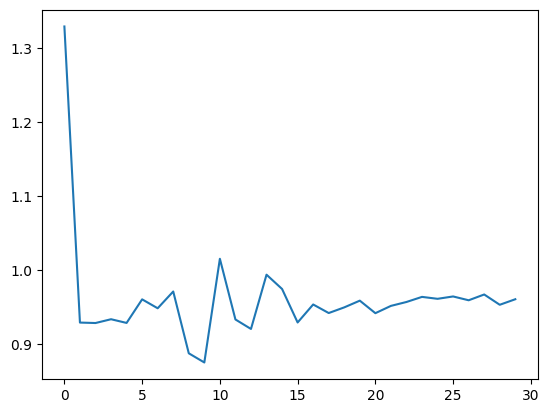

In [72]:
import matplotlib.pyplot as plt

plt.plot(history.history["val_loss"])